<a href="https://colab.research.google.com/github/CatherineDemian/feature-based-image-classifier-/blob/main/MVMilestone1Finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libs

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Loading and Preparing Dataset

#### this block doesn't need to be runned as we will be saving the arrays to just import them after

In [ ]:
# Load the Caltech-101 dataset from TensorFlow Datasets
dataset, info = tfds.load('caltech101', as_supervised=True, with_info=True)
# Print dataset information
print(info)

# Access training split (contains all examples)
AllData = dataset['train'].concatenate(dataset['test'])


tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='C:\\Users\\Ziad\\tensorflow_datasets\\caltech101\\3.0.2',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'

In [ ]:
# Define the split percentages
TrainingSplit = 0.6
ValidationSplit = 0.2
TestSplit = 0.2

# Get the total number of examples
ExamplesNumber = info.splits['train'].num_examples + info.splits['test'].num_examples

# Compute the number of examples for each split
TrainingSize = int(ExamplesNumber * TrainingSplit)
ValidationSize = int(ExamplesNumber * ValidationSplit)
TestingSize = ExamplesNumber - (TrainingSize + ValidationSize)

# Shuffle the dataset first
# seed = 42 ensures I get the same split everytime I run the code
AllData = AllData.shuffle(ExamplesNumber, seed=42)

# Now, create the splits
TrainingDataset = AllData.take(TrainingSize)
ValidationDataset = AllData.skip(TrainingSize).take(ValidationSize)
TestingDataset = AllData.skip(TrainingSize + ValidationSize).take(TestingSize)

# Print sizes of each dataset to verify
print(f"Training size: {TrainingSize}, Validation size: {ValidationSize}, Test size: {TestingSize}")



Training size: 5486, Validation size: 1828, Test size: 1830


#### Converting Tensors To Numpy Arrays


In [ ]:
def ResizeImage(Image, TargetSize=(128, 128)):
    """
    Resize the input image to the given target size.
    :param image: Input image (numpy array).
    :param target_size: Desired size (width, height).
    :return: Resized image.
    """
    ResizedImage = tf.image.resize(Image, TargetSize)

    ResizedImage = tf.clip_by_value(ResizedImage, 0, 255)

    # If the image is float, normalize to the [0, 1] range
    if ResizedImage.dtype == tf.float32:
        ResizedImage = ResizedImage / 255.0
    return ResizedImage

# Apply ResizeImage function to the datasets
def ResizeDataset(dataset, target_size=(128, 128)):

    return dataset.map(lambda image, label: (ResizeImage(image, target_size), label))

# Resize training, validation, and testing datasets
TrainingDatasetResized = ResizeDataset(TrainingDataset)
ValidationDatasetResized = ResizeDataset(ValidationDataset)
TestingDatasetResized = ResizeDataset(TestingDataset)


def dataset_to_numpy(dataset):
    image_batch = []
    label_batch = []
    for image, label in dataset:
        image_batch.append(image.numpy())  # Convert image tensor to numpy array
        label_batch.append(label.numpy())  # Convert label tensor to numpy array
    return np.array(image_batch), np.array(label_batch)

TrainingImages, TrainingLabels = dataset_to_numpy(TrainingDatasetResized)
ValidationImages, ValidationLabels = dataset_to_numpy(ValidationDatasetResized)
TestingImages, TestingLabels = dataset_to_numpy(TestingDatasetResized)
print(f"Training images shape: {TrainingImages.shape}")
print(f"Training labels shape: {TrainingLabels.shape}")
print(f"Validation images shape: {ValidationImages.shape}")
print(f"Validation labels shape: {ValidationLabels.shape}")
print(f"Testing images shape: {TestingImages.shape}")
print(f"Testing labels shape: {TestingLabels.shape}")

Training images shape: (5486, 128, 128, 3)
Training labels shape: (5486,)
Validation images shape: (1828, 128, 128, 3)
Validation labels shape: (1828,)
Testing images shape: (1830, 128, 128, 3)
Testing labels shape: (1830,)


In [ ]:
np.save('TrainingImages.npy', TrainingImages)
np.save('TrainingLabels.npy', TrainingLabels)
np.save('ValidationImages.npy', ValidationImages)
np.save('ValidationLabels.npy', ValidationLabels)
np.save('TestingImages.npy', TestingImages)
np.save('TestingLabels.npy', TestingLabels)


# Loading Dataset

In [ ]:
TrainingImages = np.load('TrainingImages.npy')
TrainingLabels = np.load('TrainingLabels.npy')
ValidationImages = np.load('ValidationImages.npy')
ValidationLabels = np.load('ValidationLabels.npy')
TestingImages = np.load('TestingImages.npy')
TestingLabels = np.load('TestingLabels.npy')


# Checking content

In [ ]:
# Count the number of images for each class in the training dataset
unique_classes, counts = np.unique(TestingLabels, return_counts=True)
# unique_classes, counts = np.unique(ValidationLabels, return_counts=True)
# unique_classes, counts = np.unique(TrainingLabels, return_counts=True)
# Print the results
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} images")


Class 0: 14 images
Class 1: 175 images
Class 2: 8 images
Class 3: 9 images
Class 4: 83 images
Class 5: 12 images
Class 6: 10 images
Class 7: 9 images
Class 8: 5 images
Class 9: 24 images
Class 10: 16 images
Class 11: 4 images
Class 12: 17 images
Class 13: 16 images
Class 14: 13 images
Class 15: 9 images
Class 16: 23 images
Class 17: 16 images
Class 18: 11 images
Class 19: 11 images
Class 20: 18 images
Class 21: 10 images
Class 22: 20 images
Class 23: 16 images
Class 24: 13 images
Class 25: 12 images
Class 26: 15 images
Class 27: 12 images
Class 28: 17 images
Class 29: 8 images
Class 30: 9 images
Class 31: 18 images
Class 32: 16 images
Class 33: 14 images
Class 34: 7 images
Class 35: 16 images
Class 36: 18 images
Class 37: 72 images
Class 38: 101 images
Class 39: 11 images
Class 40: 8 images
Class 41: 11 images
Class 42: 2 images
Class 43: 9 images
Class 44: 12 images
Class 45: 20 images
Class 46: 23 images
Class 47: 10 images
Class 48: 9 images
Class 49: 21 images
Class 50: 13 images
C

# Visualising Some of the data

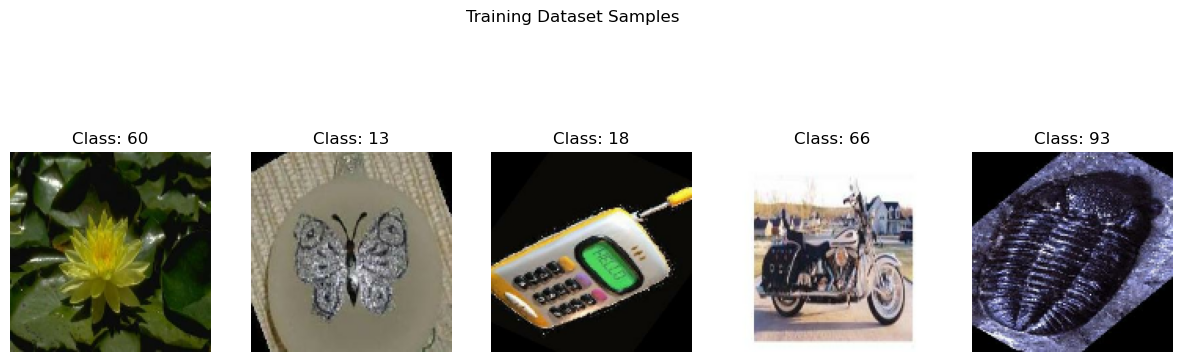

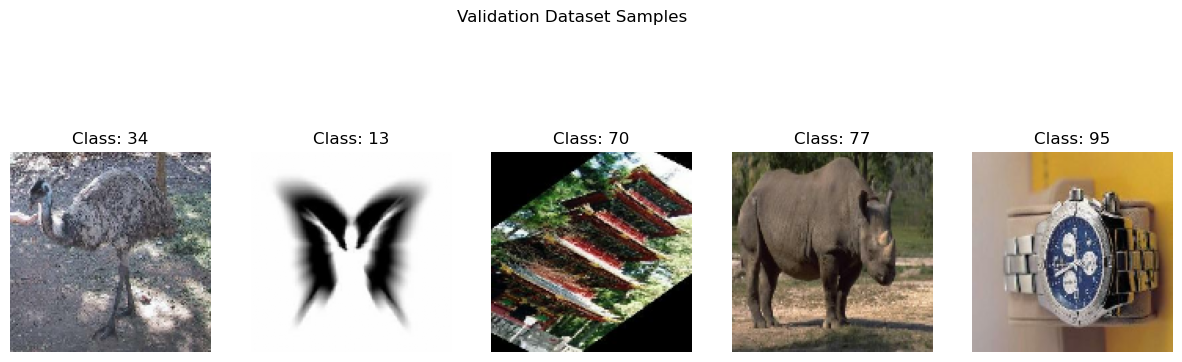

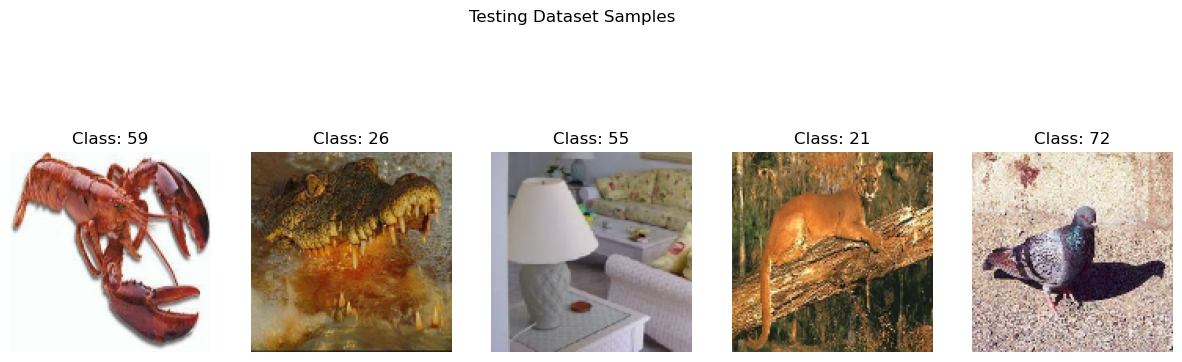

In [ ]:
def VisualizeSamples(images, labels, num_samples=5, title="Dataset Samples"):
    """
    Visualize a few samples from the dataset.
    :param images: NumPy array of images.
    :param labels: NumPy array of labels.
    :param num_samples: Number of samples to display per call.
    :param title: Title for the plot.
    """
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])  # Visualize the image
        plt.title(f"Class: {labels[i]}")  # Display the corresponding label
        plt.axis('off')  # Hide axes for better clarity
    plt.suptitle(title)
    plt.show()

# Visualize training dataset samples
VisualizeSamples(TrainingImages,TrainingLabels, num_samples=5, title="Training Dataset Samples")

# Visualize validation dataset samples
VisualizeSamples(ValidationImages,ValidationLabels, num_samples=5, title="Validation Dataset Samples")

# Visualize testing dataset samples
VisualizeSamples(TestingImages,TestingLabels, num_samples=5, title="Testing Dataset Samples")


# Image Preprocessing

In [ ]:
def ImagePreprocessingToHOG(Image):

    gray_image = cv2.cvtColor(Image, cv2.COLOR_RGB2GRAY) * 255
    # edges = cv2.Canny(np.uint8(gray_image), threshold1=100, threshold2=200)
    # SharpenedImage = np.clip(gray_image + edges, 0, 255).astype(np.uint8)

    return gray_image

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def PlotConfusionMatrix(true_labels, predicted_labels):

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(30, 27))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()


# Calculating Optimum PCA for HOG

#### as the hog features vector is so large and this may be computationaly expensive for no reason, this function tells you the accepted number of Features within a variance of 95% so that we don't remove any importaint features  

In [ ]:
def DeterminePCAComponents(data, variance_threshold=0.95):

    pca = PCA()
    pca.fit(data)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to retain the given variance
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Plot the cumulative variance for visualization
    plt.plot(cumulative_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100:.1f}% Variance')
    plt.legend()
    plt.show()

    return n_components



#### Testing

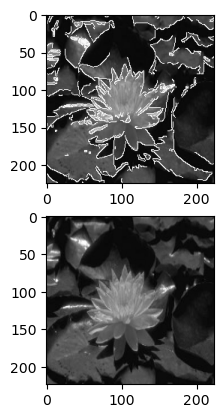

In [ ]:
IamTrying = ImagePreprocessingToHOG(TrainingImages[0])
IamTryingGray = cv2.cvtColor(TrainingImages[0], cv2.COLOR_RGB2GRAY) * 255

plt.subplot(2,1,1)
plt.imshow(IamTrying, cmap='gray')
plt.subplot(2,1,2)
plt.imshow(IamTryingGray, cmap='gray')

# Histogram Of Oriented Gradients

In [ ]:
# Define HOG descriptor parameters
winSize = (128,128)          # Window size (usually the size of the input image or patch)
blockSize = (16, 16)         # Size of a block
blockStride = (8, 8)         # Stride between blocks
cellSize = (8, 8)            # Size of a cell within a block
nbins = 9                    # Number of histogram bins

# Initialize the HOG descriptor
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

def ExtractHOGFeatures(image):
    # Convert image to grayscale (HOG operates on grayscale images)
    HOGPreprocessedImage = ImagePreprocessingToHOG(image)
    # Compute HOG features
    hist = hog.compute(np.uint8(HOGPreprocessedImage))

    # Return features as a 1D array
    return hist

# Function to extract HOG features from a dataset of images
def ExtractHOGFromDataset(images):
    hog_features = []
    for image in images:
        features = ExtractHOGFeatures(image)
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features from the datasets
TrainingImagesHOG = ExtractHOGFromDataset(TrainingImages)
ValidationImagesHOG = ExtractHOGFromDataset(ValidationImages)
TestingImagesHOG = ExtractHOGFromDataset(TestingImages)

In [ ]:
TrainingImagesHOG.shape

(5486, 8100)

### Determining the Optimal number of features for HOG

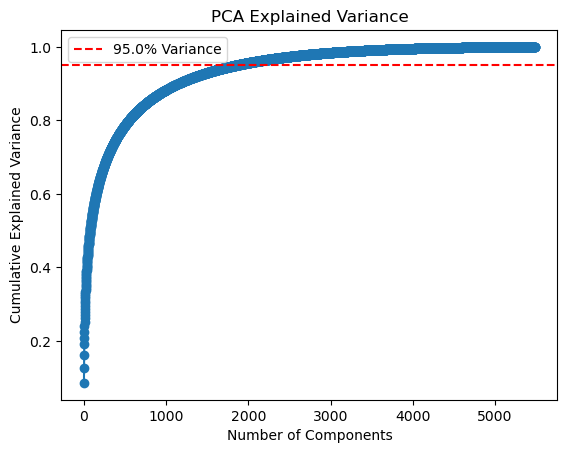

Number of PCA components to retain 95% variance: 1850


In [ ]:
n_components = DeterminePCAComponents(TrainingImagesHOG, variance_threshold=0.95)
print(f"Number of PCA components to retain 95% variance: {n_components}")

### Minimizing the number of features

In [ ]:
pca = PCA(n_components=1850)
TrainingImagesHOGPCA = pca.fit_transform(TrainingImagesHOG)
ValidationImagesHOGPCA = pca.transform(ValidationImagesHOG)
TestingImagesHOGPCA = pca.transform(TestingImagesHOG)

# Colored Histogram


## RGB Color mode

In [ ]:
def Extract_Color_histogram(image):
    # Define colors for the histogram (BGR: Blue, Green, Red)
    colors = ('b', 'g', 'r')

    # Convert image to float32 for scaling
    img_float = image.astype(np.float32)

    # Apply scaling (multiply by 255 to expand the range) and clipping to maintain valid pixel values
    img_float = np.clip(img_float * 255, 0, 255)

    # Convert back to uint8 after scaling
    img_scaled = img_float.astype(np.uint8)

    # Convert image to RGB for proper visualization
    img_rgb = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2RGB)

    # Initialize an empty list to store histograms
    color_hist = []

    # Compute and plot the color histograms (one per channel)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_scaled], [i], None, [256], [0, 255])  # Calculate the histogram
        hist = hist / hist.sum()  # Normalize the histogram
        color_hist.append(hist.flatten())  # Flatten and store the histogram for each channel

    # Concatenate the histograms for all channels to create the feature vector
    color_hist_feature_vector = np.concatenate(color_hist)

    # Compute and plot the color histograms (one per channel)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_scaled], [i], None, [256], [0, 255])  # Calculate the histogram
        hist = hist / hist.sum()  # Normalize the histogram

    return color_hist_feature_vector

def ExtractColorHistFromDataset(images):
    color_features = []
    for image in images:
        features = Extract_Color_histogram(image)
        color_features.append(features)
    return np.array(color_features)

# Extract HOG features from the datasets
TrainingImagesCH = ExtractColorHistFromDataset(TrainingImages)
ValidationImagesCH = ExtractColorHistFromDataset(ValidationImages)
TestingImagesCH = ExtractColorHistFromDataset(TestingImages)

In [ ]:
TrainingImagesCH.shape

(5486, 768)

## HSV Color Mode

In [ ]:
def extract_hsv_value_feature_vector(image):

    img_float = image.astype(np.float32)
    img_float = np.clip(img_float * 255, 0, 255)
    img_scaled = img_float.astype(np.uint8)
    hsv_image = cv2.cvtColor(img_scaled, cv2.COLOR_RGB2HSV)
    _, _, value_channel = cv2.split(hsv_image)
    feature_vector = value_channel.flatten()
    return feature_vector

def ExtractColorHistVFromDataset(images):
    colorV_features = []  # Initialize the list to hold the feature vectors
    for image in images:
        features = extract_hsv_value_feature_vector(image)  # Extract feature vector from each image
        colorV_features.append(features)  # Append the feature vector to the list

    # Return the numpy array of feature vectors
    return np.array(colorV_features)

# Example usage:
# Extract Color Hist V features from the datasets
TrainingImagesCHV = ExtractColorHistVFromDataset(TrainingImages)
ValidationImagesCHV = ExtractColorHistVFromDataset(ValidationImages)
TestingImagesCHV = ExtractColorHistVFromDataset(TestingImages)

In [ ]:
TrainingImagesCHV.shape

(5486, 16384)

### Determining the Optimal number of features for CHV

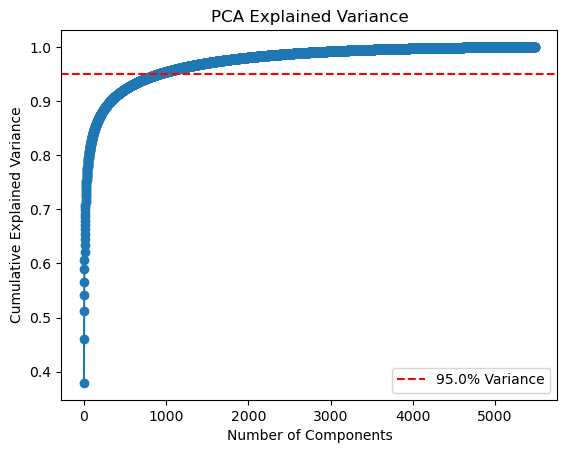

Number of PCA components to retain 95% variance: 911


In [ ]:
n_components = DeterminePCAComponents(TrainingImagesCHV, variance_threshold=0.95)
print(f"Number of PCA components to retain 95% variance: {n_components}")

### Minimizing the number of features

In [ ]:
pca = PCA(n_components=911)
TrainingImagesCHVPCA = pca.fit_transform(TrainingImagesCHV)
ValidationImagesCHVPCA = pca.transform(ValidationImagesCHV)
TestingImagesCHVPCA = pca.transform(TestingImagesCHV)

# LBPH

In [ ]:
def Extract_LBP_histogram(image):
    radius=1
    n_points = 8 * radius  # Number of points in the LBP pattern (default = 8)

    # Convert to float32 for LBP computation
    img_float = image.astype(np.float32)

    # Apply scaling and clip to maintain valid pixel values
    img_scaled = np.clip(img_float * 255, 0, 255)
    img_scaled = img_scaled.astype(np.uint8)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)

    # Apply LBP and compute histogram (using 'uniform' method)
    lbp_image = local_binary_pattern(gray_img, n_points, radius, method='default')

    # Convert the LBP image to uint8 and calculate the histogram
    lbp_hist = cv2.calcHist([lbp_image.astype(np.uint8)], [0], None, [256], [0, 255])
    lbp_hist /= lbp_hist.sum()  # Normalize the histogram

    # Return the LBP histogram as a 1D feature vector
    return lbp_hist.flatten()

def ExtractLBPHFromDataset(images):
    LBPH_features = []
    for image in images:
        features = Extract_LBP_histogram(image)
        LBPH_features.append(features)
    return np.array(LBPH_features)

# Extract HOG features from the datasets
TrainingImagesLBPH = ExtractLBPHFromDataset(TrainingImages)
ValidationImagesLBPH = ExtractLBPHFromDataset(ValidationImages)
TestingImagesLBPH = ExtractLBPHFromDataset(TestingImages)

In [ ]:
TrainingImagesLBPH.shape

(5486, 256)

# KNN Classification


In [ ]:
# Euclidean distance function
def euclidean_distance(point1, point2):

    return np.sqrt(np.sum((point1 - point2) ** 2))

# k-NN prediction function
def knn_predict(PassedData, train_data, train_labels, k=3):

    predictions = []

    for ValidatePoint in PassedData:
        # Compute distances to all training points
        distances = [euclidean_distance(ValidatePoint, train_point) for train_point in train_data]

        # Get indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:k]

        # Get the labels of the k nearest neighbors
        k_labels = [train_labels[idx] for idx in k_indices]

        # Majority voting
        most_common_label = Counter(k_labels).most_common(1)[0][0]
        predictions.append(most_common_label)

    return np.array(predictions)




# K-means

### Implementation


In [ ]:
def k_means_plus_plus(X, n_clusters):

    # Initialize the first centroid randomly
    centroids = [X[np.random.choice(X.shape[0])]]

    for _ in range(1, n_clusters):
        # Calculate the distance from each point to the closest centroid
        distances = np.min(np.linalg.norm(X[:, np.newaxis] - np.array(centroids), axis=2), axis=1)

        # Choose the next centroid with a probability proportional to the distance squared
        probabilities = distances**2
        probabilities /= probabilities.sum()  # Normalize to sum to 1
        next_centroid = X[np.random.choice(X.shape[0], p=probabilities)]
        centroids.append(next_centroid)

    return np.array(centroids)

def k_meanss(X, n_clusters, max_iter=400, tol=1e-4):

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize centroids using K-Means++ initialization
    centroids = k_means_plus_plus(X_scaled, n_clusters)

    for iteration in range(max_iter):
        # Step 1: Assign each data point to the nearest centroid
        distances = np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Step 2: Recompute the centroids based on the mean of the points in each cluster
        new_centroids = np.array([
            X_scaled[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k]
            for k in range(n_clusters)
        ])

        # Step 3: Check for convergence by calculating the shift in centroids
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        if centroid_shift < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

        centroids = new_centroids

    # Plot the clusters and centroids
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7, label="Data Points")
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
    plt.title("K-Means Clustering with K-Means++ Initialization")
    plt.xlabel("Feature 1 (Scaled)")
    plt.ylabel("Feature 2 (Scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return labels, centroids

### Visualization

In [ ]:
def visualize_images_per_cluster(images, labels, n_clusters):
    """
    Visualize images for each cluster.

    Parameters:
        images (list or ndarray): List of original images used for clustering.
        labels (list or ndarray): Cluster labels for each image.
        n_clusters (int): Number of clusters.
    """
    assert len(images) == len(labels), "Number of images and labels must match!"

    for cluster in range(n_clusters):
        cluster_indices = np.where(labels == cluster)[0]  # Get indices for current cluster
        cluster_images = [images[i] for i in cluster_indices]

        # Display the first few images in this cluster
        print(f"Cluster {cluster}: {len(cluster_images)} images")
        n_display = min(5, len(cluster_images))  # Display up to 5 images per cluster

        if n_display > 0:
            plt.figure(figsize=(15, 5))
            for i in range(n_display):
                plt.subplot(1, n_display, i + 1)
                plt.imshow(cv2.cvtColor(cluster_images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
                plt.axis("off")
                plt.title(f"Cluster {cluster}")
            plt.show()

### Modularized K-Means with Accuracy

In [ ]:
# Function to map predicted clusters to true labels
def match_clusters_to_labels(predicted_labels, true_labels, n_clusters):
    """
    Maps predicted cluster labels to true labels by finding the most common true label for each cluster.

    Parameters:
    - predicted_labels: Array of predicted cluster labels from K-Means.
    - true_labels: Array of true labels (ground truth).
    - n_clusters: Number of clusters.

    Returns:
    - mapped_labels: Array of mapped true labels corresponding to each predicted label.
    """
    mapped_labels = np.zeros_like(predicted_labels)

    for cluster in range(n_clusters):
        # Mask to find points in this cluster
        mask = (predicted_labels == cluster)

        # Extract true labels for this cluster
        cluster_true_labels = true_labels[mask]

        if len(cluster_true_labels) > 0:
            # Find the most common label using np.bincount
            most_common_label = np.bincount(cluster_true_labels).argmax()
            mapped_labels[mask] = most_common_label
        else:
            # If the cluster is empty, leave it unmapped
            continue

    return mapped_labels

# Function to calculate accuracy
def calculate_accuracy(predicted_labels, true_labels):
    """
    Calculate accuracy by comparing predicted labels and true labels.

    Parameters:
    - predicted_labels: Array of predicted labels (after mapping clusters to true labels).
    - true_labels: Array of true labels (ground truth).

    Returns:
    - accuracy: Accuracy percentage.
    """
    accuracy = accuracy_score(true_labels, predicted_labels) * 100
    return accuracy



# KNN Classification using HOG features

In [ ]:
accuracies = []

In [ ]:
# k-NN classifier implementation
k = 11  # Number of neighbors ---------- we tried 1, 3, 5, 7, 11

# Perform predictions
predictions = knn_predict(ValidationImagesHOG, TrainingImagesHOG, TrainingLabels, k=k)

# Evaluate accuracy
accuracy = np.mean(predictions == ValidationLabels)

accuracies.append(accuracy)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 53.83%


In [ ]:
accuracies

[0.7839168490153173,
 0.7521881838074398,
 0.6838074398249453,
 0.6285557986870897,
 0.5382932166301969]

In [ ]:
k = 5  # we chose 5 not 1 to prevent overfitting

# Perform predictions
predictions = knn_predict(TestingImagesHOG, TrainingImagesHOG, TrainingLabels, k=k)

# Evaluate accuracy
accuracy_KNN_HOG = np.mean(predictions == TestingLabels)
print(f"Accuracy: {accuracy_KNN_HOG * 100:.2f}%")


Accuracy: 68.52%


### Visualizing the confusion matrix


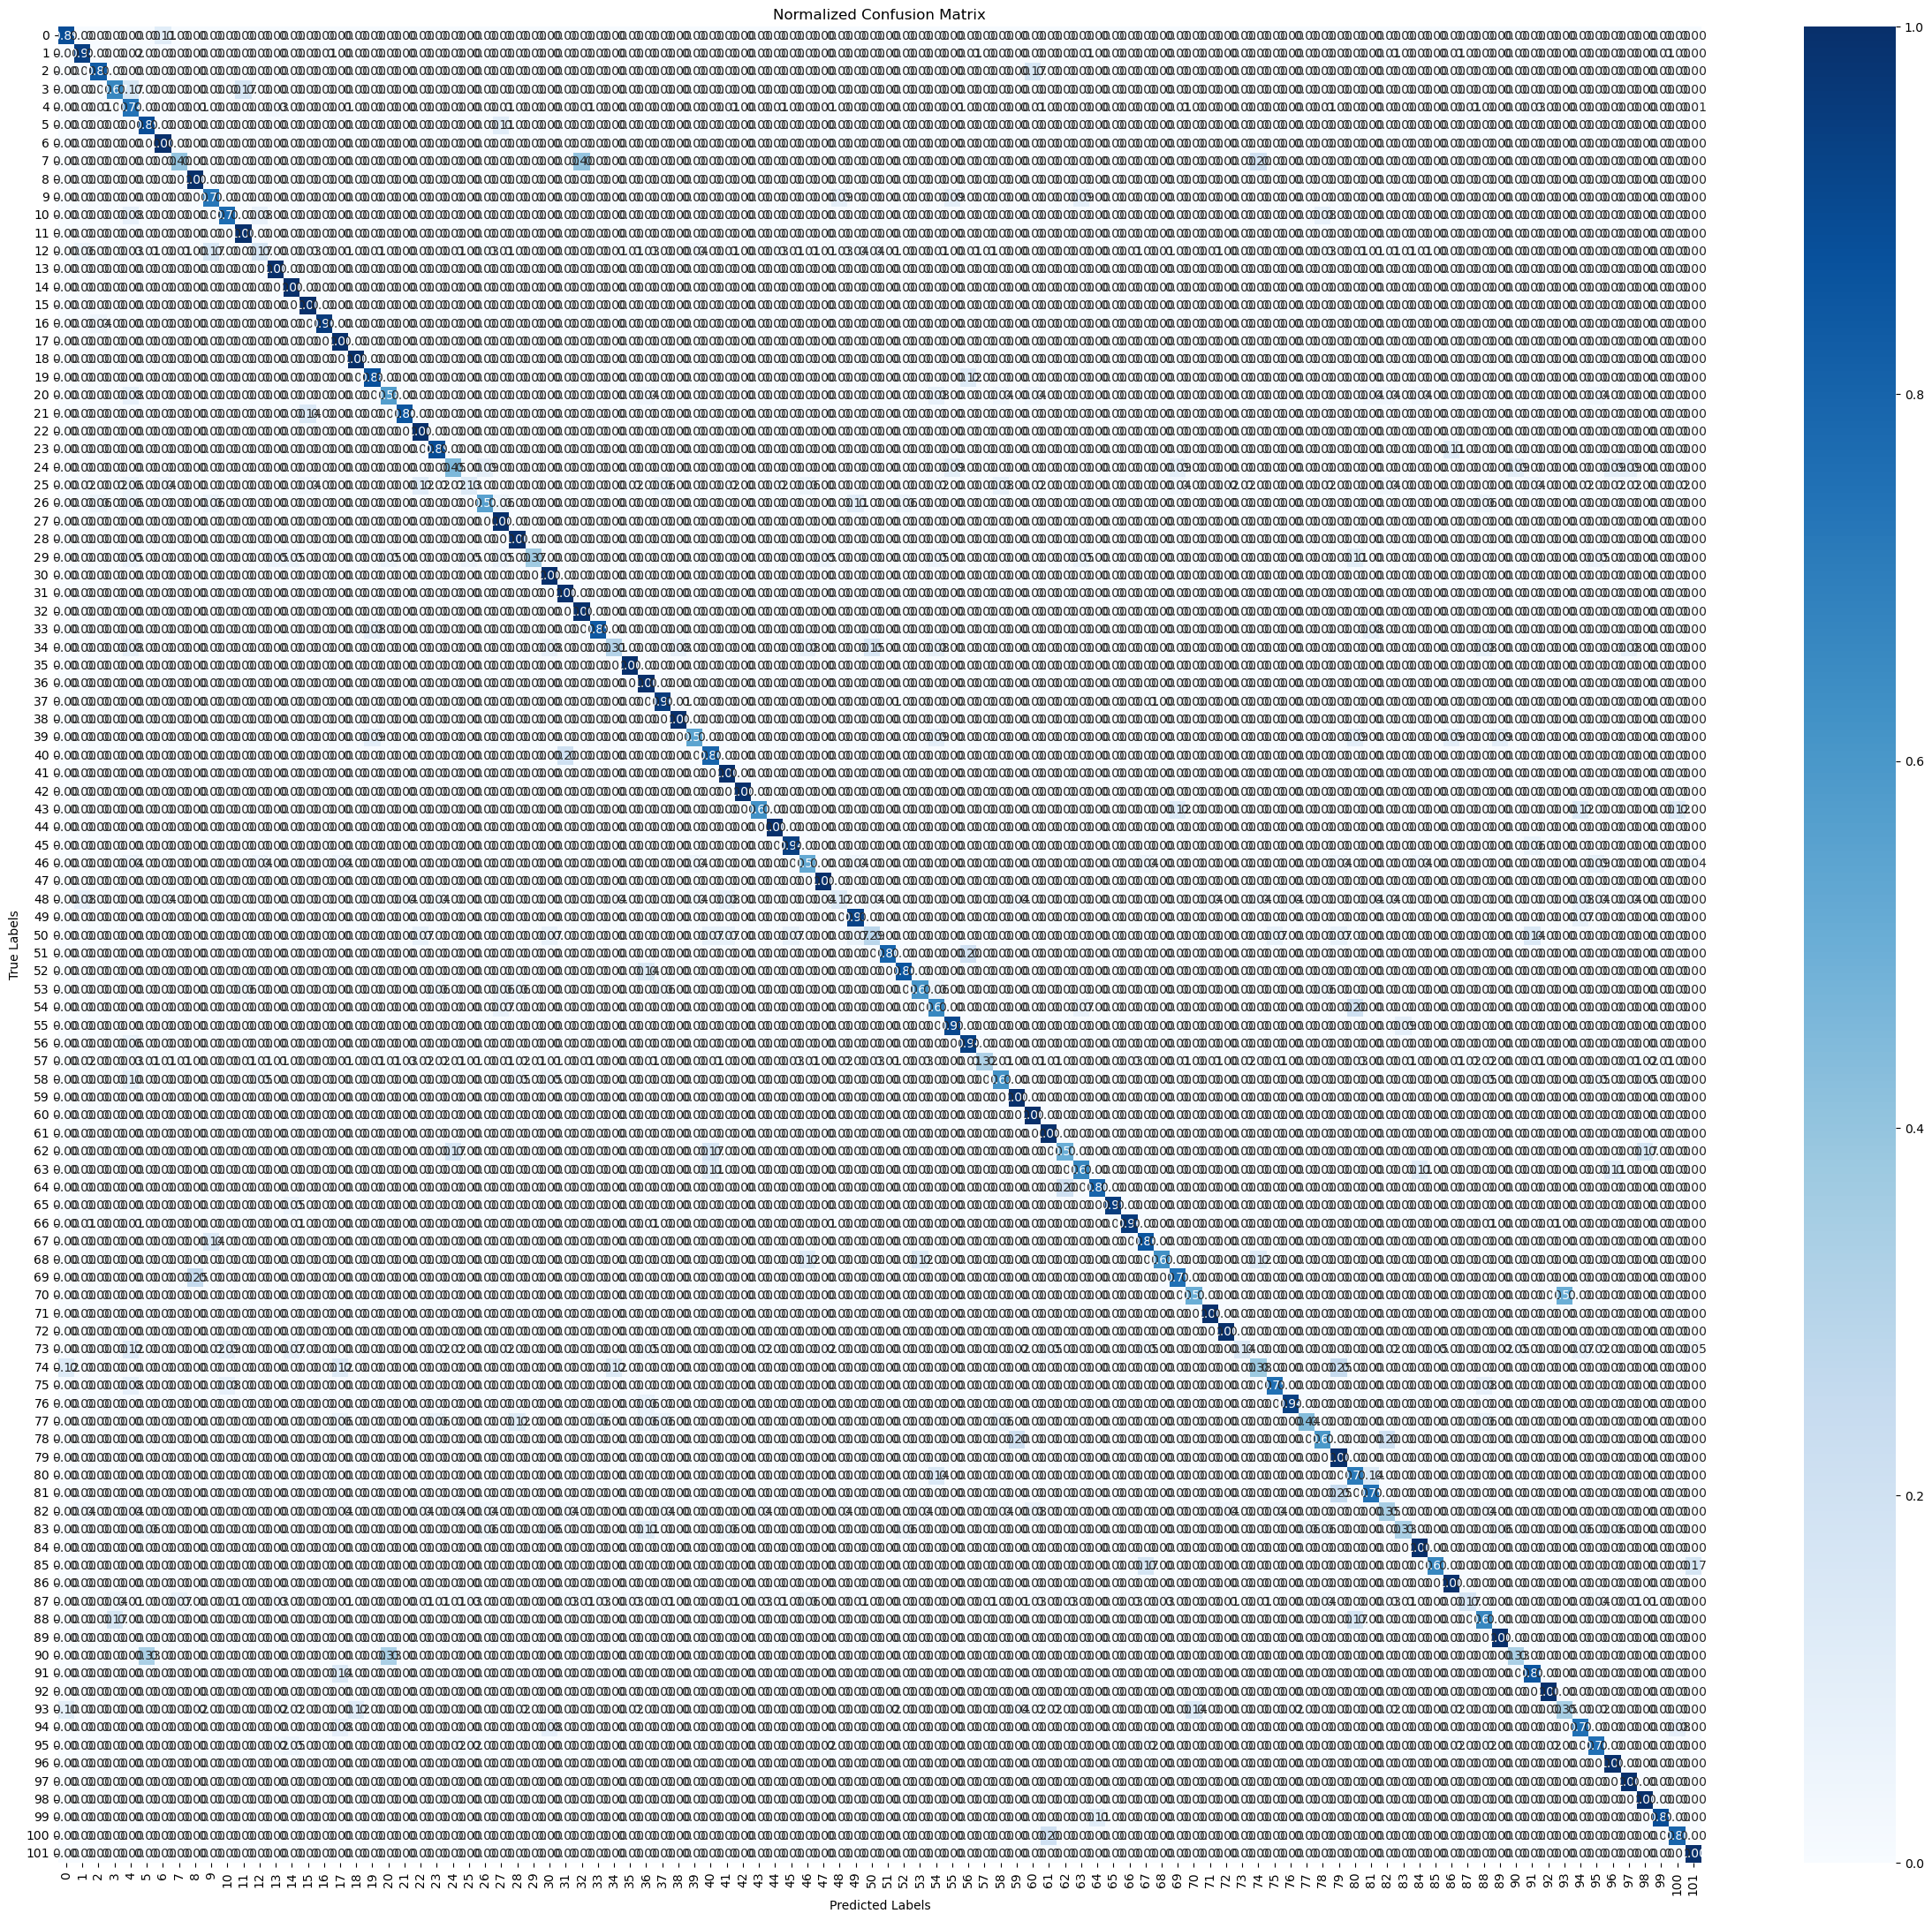

In [ ]:
PlotConfusionMatrix(predictions, TestingLabels)

# KNN Classification Using Colored Histogram RGB

In [ ]:
accuraciesCH = []

In [ ]:
# k-NN classifier implementation
k = 11  # Number of neighbors ---------- we tried 1, 3, 5, 7, 11

# Perform predictions
predictionsCH = knn_predict(ValidationImagesCH, TrainingImagesCH, TrainingLabels, k=k)

# Evaluate accuracy
accuracy = np.mean(predictionsCH == ValidationLabels)

accuraciesCH.append(accuracy)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 40.21%


In [ ]:
accuraciesCH

[0.6914660831509847,
 0.6438730853391685,
 0.5683807439824945,
 0.4934354485776805,
 0.4020787746170678]

In [ ]:
k = 5  # we chose 5 not 1 to prevent overfitting

# Perform predictions
predictionsCH = knn_predict(TestingImagesCH, TrainingImagesCH, TrainingLabels, k=k)

# Evaluate accuracy
accuracy_KNN_CH = np.mean(predictionsCH == TestingLabels)
print(f"Accuracy: {accuracy_KNN_CH * 100:.2f}%")

Accuracy: 56.89%


# KNN Classification Using Colored Histogram HSV

In [ ]:
accuraciesCHV = []

In [ ]:
# k-NN classifier implementation
k = 11  # Number of neighbors ---------- we tried 1, 3, 5, 7, 11

# Perform predictions
predictionsCHV = knn_predict(ValidationImagesCHV, TrainingImagesCHV, TrainingLabels, k=k)

# Evaluate accuracy
accuracy = np.mean(predictionsCHV == ValidationLabels)

accuraciesCHV.append(accuracy)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 31.84%


In [ ]:
accuraciesCHV

[0.712800875273523,
 0.6329321663019694,
 0.4863238512035011,
 0.3966083150984683,
 0.31838074398249455]

In [ ]:
k = 3  # we chose 3 not 1 to prevent overfitting

# Perform predictions
predictionsCHV = knn_predict(TestingImagesCHV, TrainingImagesCHV, TrainingLabels, k=k)

# Evaluate accuracy
accuracy_KNN_CHV = np.mean(predictionsCHV == TestingLabels)
print(f"Accuracy: {accuracy_KNN_CHV * 100:.2f}%")

Accuracy: 63.72%


# KNN Classification Using LBPH

In [ ]:
accuraciesLBPH = []

In [ ]:
# k-NN classifier implementation
k = 11  # Number of neighbors ---------- we tried 1, 3, 5, 7, 11

# Perform predictions
predictionsLBPH = knn_predict(ValidationImagesLBPH, TrainingImagesLBPH, TrainingLabels, k=k)

# Evaluate accuracy
accuracy = np.mean(predictionsLBPH == ValidationLabels)

accuraciesLBPH.append(accuracy)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 47.87%


In [ ]:
accuraciesLBPH

[0.7407002188183808,
 0.7073304157549234,
 0.6285557986870897,
 0.5612691466083151,
 0.4786652078774617]

In [ ]:
k = 5  # we chose 5 not 1 to prevent overfitting

# Perform predictions
predictions = knn_predict(TestingImagesLBPH, TrainingImagesLBPH, TrainingLabels, k=k)

# Evaluate accuracy
accuracy_KNN_LBPH = np.mean(predictions == TestingLabels)
print(f"Accuracy: {accuracy_KNN_LBPH * 100:.2f}%")

Accuracy: 62.84%


# K-Means with Colored Histogram

Converged after 36 iterations.


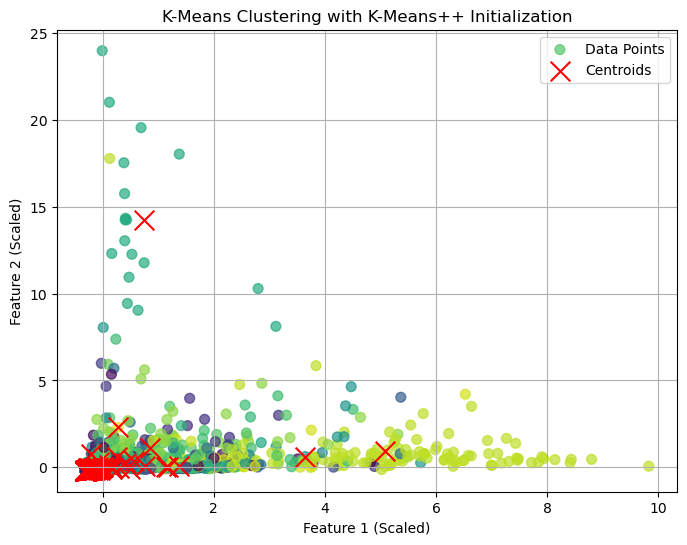

Converged after 21 iterations.


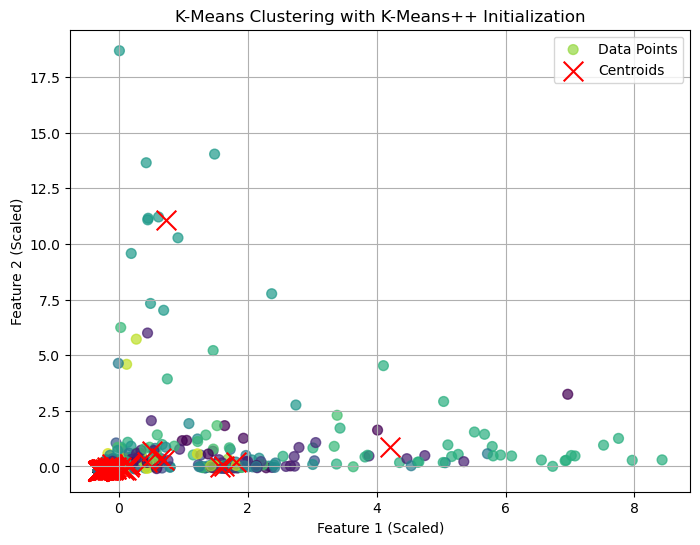

Converged after 31 iterations.


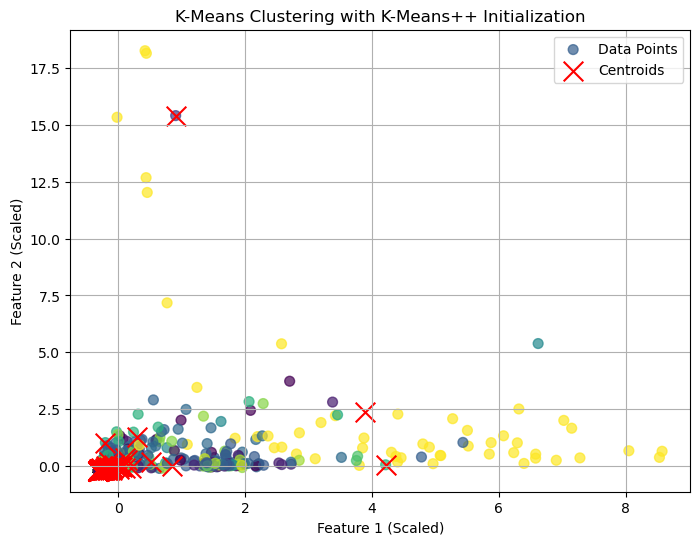

Training Accuracy: 17.52%
Validation Accuracy: 20.30%
Testing Accuracy: 19.84%


In [ ]:
predicted_train_labelsCH, centroids = k_meanss(TrainingImagesCH, 101)
predicted_val_labelsCH, centroids = k_meanss(ValidationImagesCH, 101)
predicted_test_labelsCH, centroids = k_meanss(TestingImagesCH, 101)

# Define the number of clusters
n_clusters = 101  # Match the number of clusters used in K-Means

# Map predicted cluster labels to true labels
mapped_train_labelsCH = match_clusters_to_labels(predicted_train_labelsCH, TrainingLabels, n_clusters)
mapped_val_labelsCH = match_clusters_to_labels(predicted_val_labelsCH, ValidationLabels, n_clusters)
mapped_test_labelsCH = match_clusters_to_labels(predicted_test_labelsCH, TestingLabels, n_clusters)

# Calculate accuracy for training, validation, and testing
train_accuracyCH = calculate_accuracy(mapped_train_labelsCH, TrainingLabels)
val_accuracyCH = calculate_accuracy(mapped_val_labelsCH, ValidationLabels)
test_accuracyCH = calculate_accuracy(mapped_test_labelsCH, TestingLabels)

# Print out the accuracies
print(f"Training Accuracy: {train_accuracyCH:.2f}%")
print(f"Validation Accuracy: {val_accuracyCH:.2f}%")
print(f"Testing Accuracy: {test_accuracyCH:.2f}%")

# K-Means with Colored Histogram Intensity

Converged after 9 iterations.


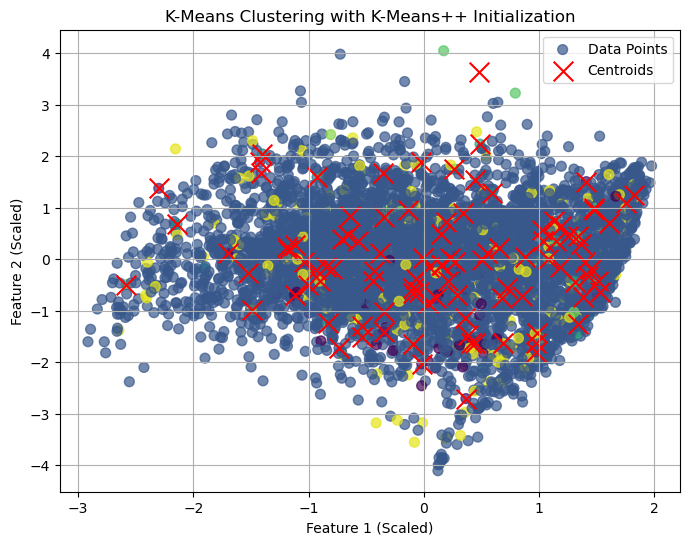

Converged after 4 iterations.


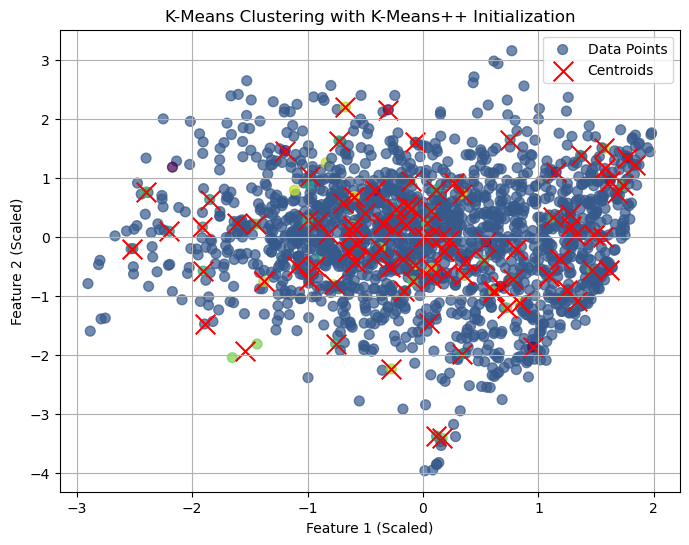

Converged after 13 iterations.


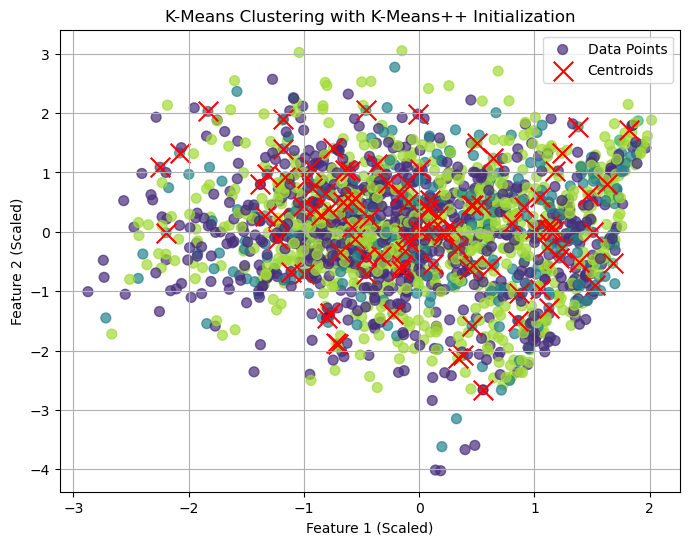

Training Accuracy: 11.34%
Validation Accuracy: 14.44%


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
predicted_train_labelsCHV, centroids = k_meanss(TrainingImagesCHVPCA, 101)
predicted_val_labelsCHV, centroids = k_meanss(ValidationImagesCHVPCA, 101)
predicted_test_labelsCHV, centroids = k_meanss(TestingImagesCHVPCA, 101)

# Define the number of clusters
n_clusters = 101  # Match the number of clusters used in K-Means

# Map predicted cluster labels to true labels
mapped_train_labelsCHV = match_clusters_to_labels(predicted_train_labelsCHV, TrainingLabels, n_clusters)
mapped_val_labelsCHV = match_clusters_to_labels(predicted_val_labelsCHV, ValidationLabels, n_clusters)
mapped_test_labelsCHV = match_clusters_to_labels(predicted_test_labelsCHV, TestingLabels, n_clusters)

# Calculate accuracy for training, validation, and testing
train_accuracyCHV = calculate_accuracy(mapped_train_labelsCHV, TrainingLabels)
val_accuracyCHV = calculate_accuracy(mapped_val_labelsCHV, ValidationLabels)
test_accuracyCHV = calculate_accuracy(mapped_test_labelsCHV, TestingLabels)

# Print out the accuracies
print(f"Training Accuracy: {train_accuracyCHV:.2f}%")
print(f"Validation Accuracy: {val_accuracyCHV:.2f}%")
print(f"Testing Accuracy: {test_accuracyCHV:.2f}%")


In [ ]:
print(f"Training Accuracy: {train_accuracyCHV:.2f}%")
print(f"Validation Accuracy: {val_accuracyCHV:.2f}%")
print(f"Testing Accuracy: {test_accuracyCHV:.2f}%")

Training Accuracy: 11.34%
Validation Accuracy: 14.44%
Testing Accuracy: 15.46%


# K-Means with LBPH

Converged after 29 iterations.


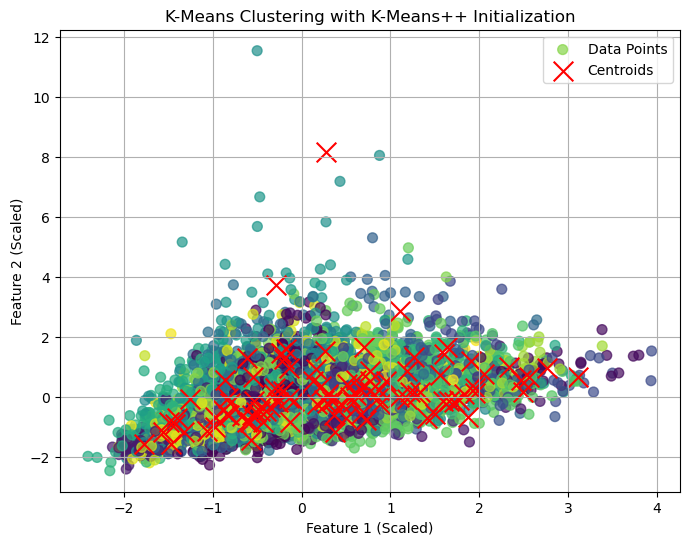

Converged after 12 iterations.


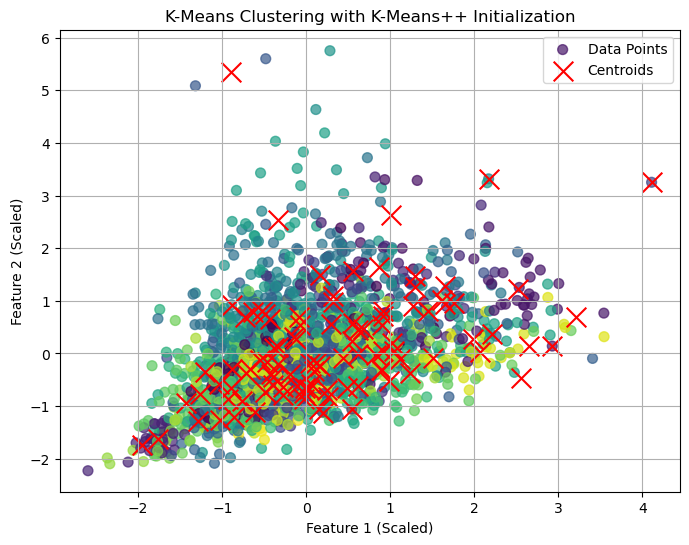

Converged after 16 iterations.


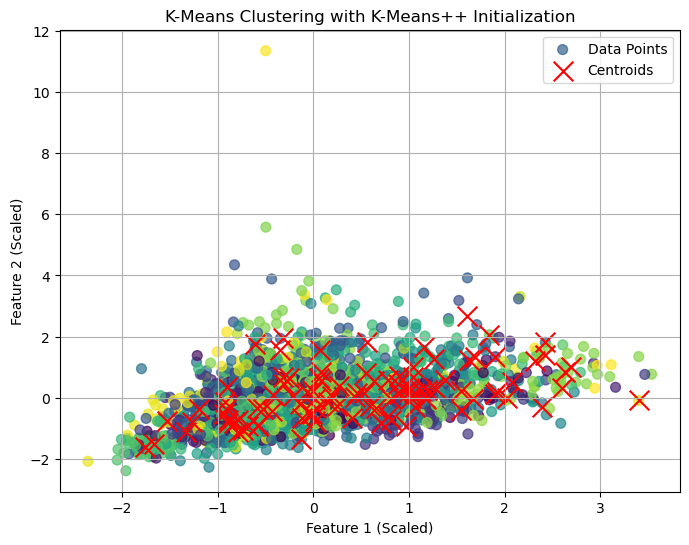

Training Accuracy: 31.01%
Validation Accuracy: 33.37%
Testing Accuracy: 32.84%


In [ ]:
predicted_train_labelsLBPH, centroids = k_meanss(TrainingImagesLBPH, 101)
predicted_val_labelsLBPH, centroids = k_meanss(ValidationImagesLBPH, 101)
predicted_test_labelsLBPH, centroids = k_meanss(TestingImagesLBPH, 101)

# Define the number of clusters
n_clusters = 101  # Match the number of clusters used in K-Means

# Map predicted cluster labels to true labels
mapped_train_labelsLBPH = match_clusters_to_labels(predicted_train_labelsLBPH, TrainingLabels, n_clusters)
mapped_val_labelsLBPH = match_clusters_to_labels(predicted_val_labelsLBPH, ValidationLabels, n_clusters)
mapped_test_labelsLBPH = match_clusters_to_labels(predicted_test_labelsLBPH, TestingLabels, n_clusters)

# Calculate accuracy for training, validation, and testing
train_accuracyLBPH = calculate_accuracy(mapped_train_labelsLBPH, TrainingLabels)
val_accuracyLBPH = calculate_accuracy(mapped_val_labelsLBPH, ValidationLabels)
test_accuracyLBPH = calculate_accuracy(mapped_test_labelsLBPH, TestingLabels)

# Print out the accuracies
print(f"Training Accuracy: {train_accuracyLBPH:.2f}%")
print(f"Validation Accuracy: {val_accuracyLBPH:.2f}%")
print(f"Testing Accuracy: {test_accuracyLBPH:.2f}%")

# K-means with HOG

Converged after 10 iterations.


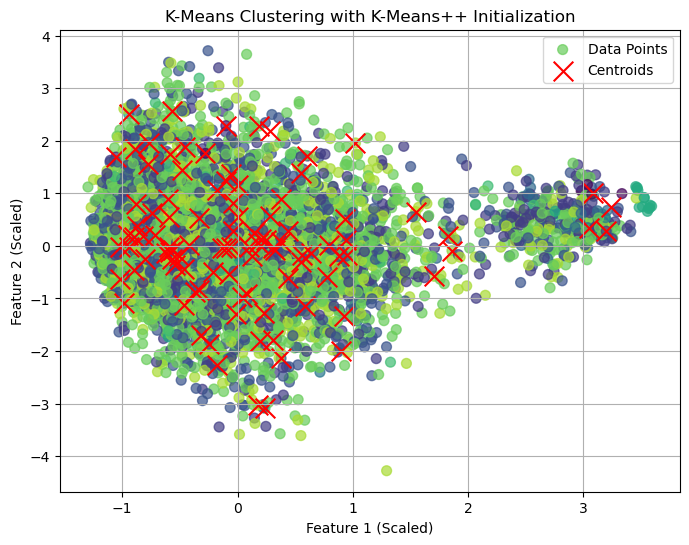

Converged after 7 iterations.


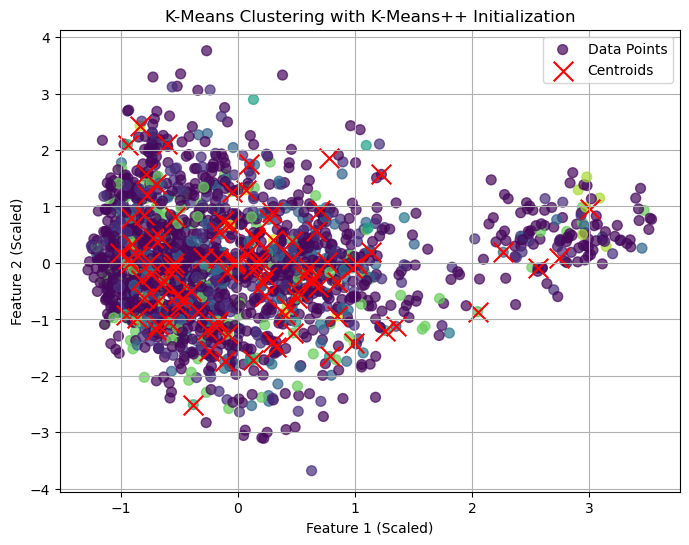

Converged after 8 iterations.


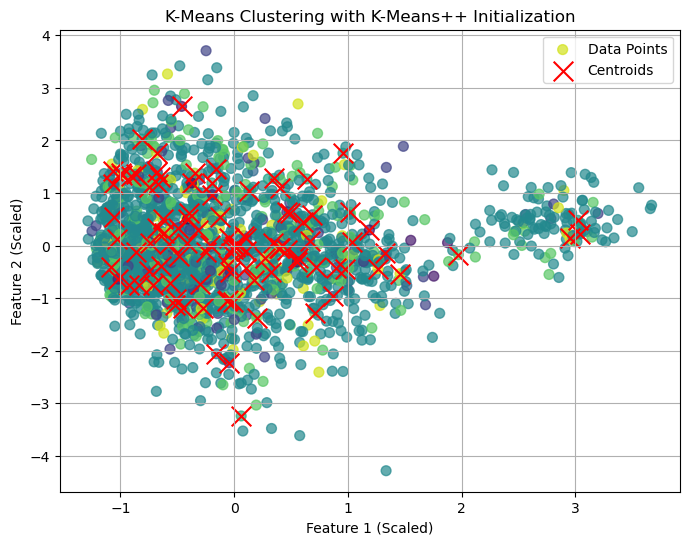

Training Accuracy: 12.43%
Validation Accuracy: 15.81%
Testing Accuracy: 15.08%


In [ ]:
predicted_train_labelsHOG, centroids = k_meanss(TrainingImagesHOGPCA, 101)
predicted_val_labelsHOG, centroids = k_meanss(ValidationImagesHOGPCA, 101)
predicted_test_labelsHOG, centroids = k_meanss(TestingImagesHOGPCA, 101)

# Define the number of clusters
n_clusters = 101  # Match the number of clusters used in K-Means

# Map predicted cluster labels to true labels
mapped_train_labelsHOG = match_clusters_to_labels(predicted_train_labelsHOG, TrainingLabels, n_clusters)
mapped_val_labelsHOG = match_clusters_to_labels(predicted_val_labelsHOG, ValidationLabels, n_clusters)
mapped_test_labelsHOG = match_clusters_to_labels(predicted_test_labelsHOG, TestingLabels, n_clusters)

# Calculate accuracy for training, validation, and testing
train_accuracyHOG = calculate_accuracy(mapped_train_labelsHOG, TrainingLabels)
val_accuracyHOG = calculate_accuracy(mapped_val_labelsHOG, ValidationLabels)
test_accuracyHOG = calculate_accuracy(mapped_test_labelsHOG, TestingLabels)

# Print out the accuracies
print(f"Training Accuracy: {train_accuracyHOG:.2f}%")
print(f"Validation Accuracy: {val_accuracyHOG:.2f}%")
print(f"Testing Accuracy: {test_accuracyHOG:.2f}%")

# SVM Classification

### Using HOG Features

#### Tuning C value

In [ ]:
# Example of testing different C values
c_values = [0.1, 1.0, 10.0, 100.0]

for c in c_values:
    svm_model = SVC(kernel='linear', C=c)
    svm_model.fit(TrainingImagesHOGPCA, TrainingLabels)
    validation_predictions_SVM_HOG = svm_model.predict(ValidationImagesHOGPCA)
    validation_accuracy_SVM_HOG = accuracy_score(ValidationLabels, validation_predictions_SVM_HOG)
    print(f"Validation accuracy for C={c}: {validation_accuracy_SVM_HOG * 100:.2f}%")


Validation accuracy for C=0.1: 86.27%
Validation accuracy for C=1.0: 86.27%
Validation accuracy for C=10.0: 86.27%
Validation accuracy for C=100.0: 86.27%


#### Validating aquired C value

In [ ]:
# Train SVM with HOG features
svm_model = SVC(kernel='linear', C=1.0)

# Train the model on the training data
svm_model.fit(TrainingImagesHOGPCA, TrainingLabels)

# Now, make predictions on the testing set
test_predictions_SVM_HOG = svm_model.predict(TestingImagesHOGPCA)

# Calculate accuracy on the test set
test_accuracy_SVM_HOG = accuracy_score(TestingLabels, test_predictions_SVM_HOG)
print(f"Test Accuracy: {test_accuracy_SVM_HOG * 100:.2f}%")

Test Accuracy: 84.37%


#### Confusion Matrix

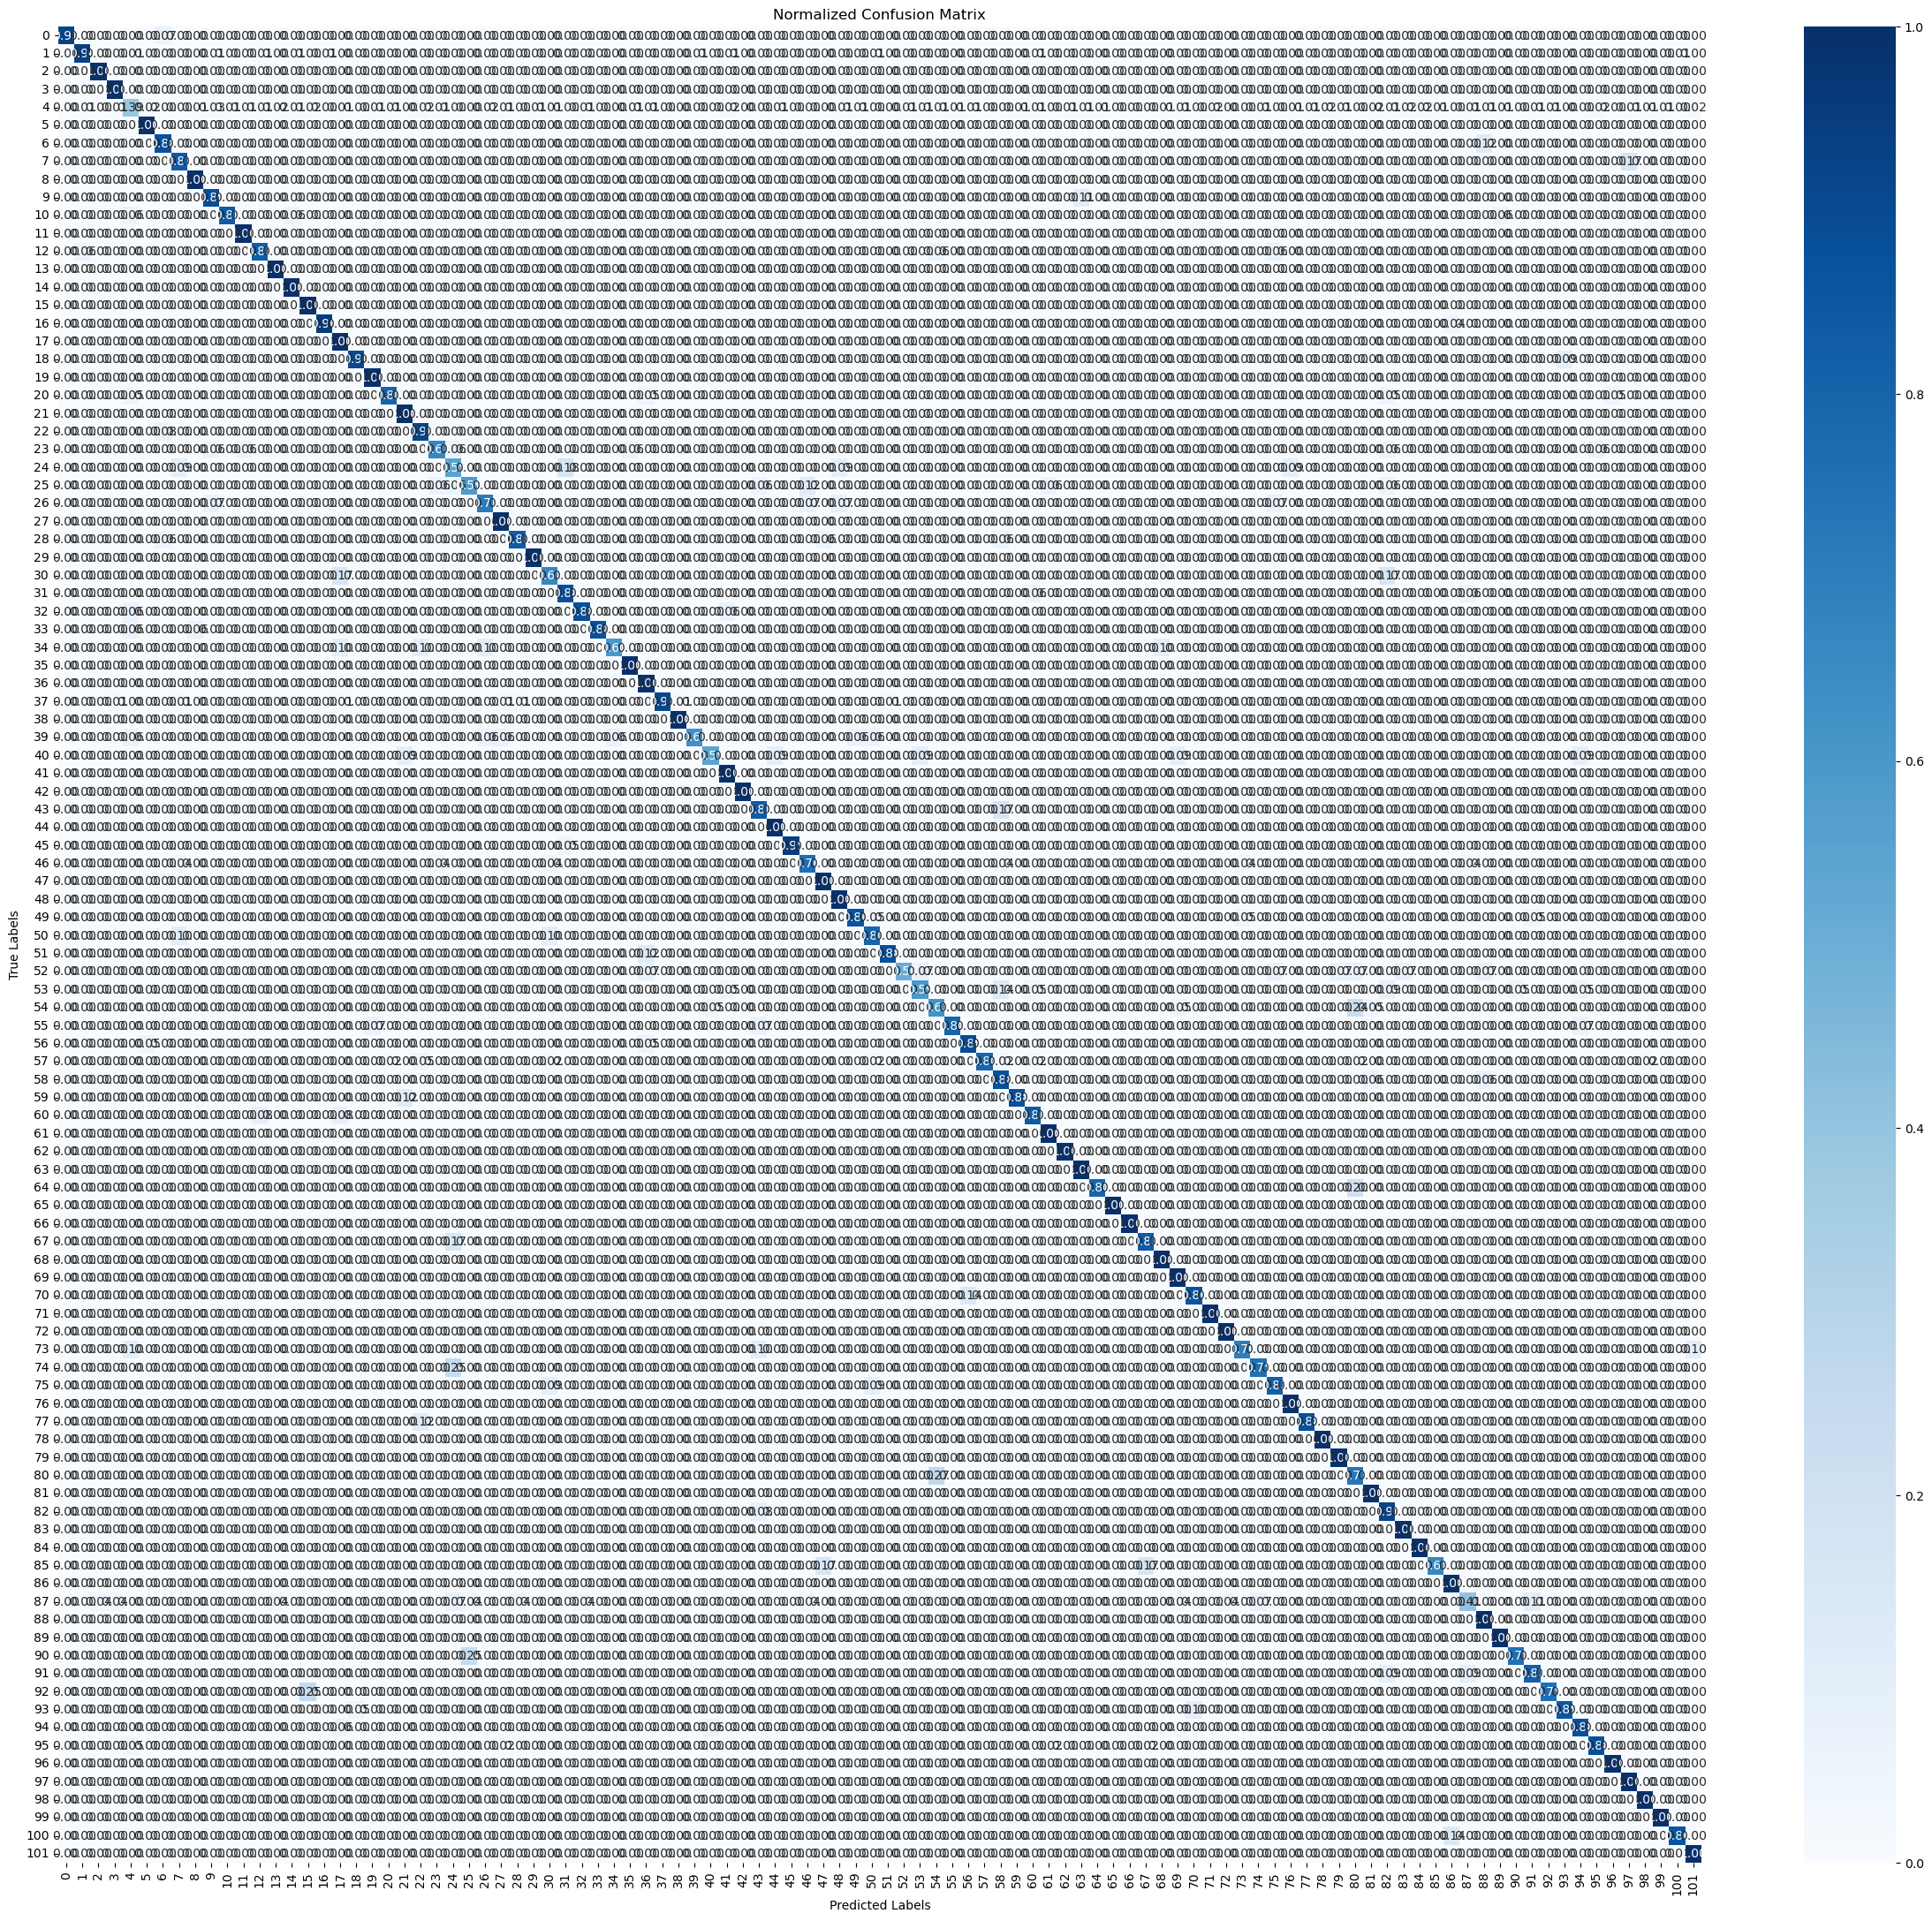

In [ ]:
PlotConfusionMatrix(test_predictions_SVM_HOG, TestingLabels)

### Using Colored Histogram "RGB"

#### Tuning C value

In [ ]:
# Example of testing different C values
c_values = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

for c in c_values:
    svm_model_CH = SVC(kernel='linear', C=c)
    svm_model_CH.fit(TrainingImagesCH, TrainingLabels)
    validation_predictions_SVM_CH = svm_model_CH.predict(ValidationImagesCH)
    validation_accuracy_SVM_CH = accuracy_score(ValidationLabels, validation_predictions_SVM_CH)
    print(f"Validation accuracy for C={c}: {validation_accuracy_SVM_CH * 100:.2f}%")


Validation accuracy for C=0.1: 11.16%
Validation accuracy for C=1.0: 16.74%
Validation accuracy for C=10.0: 27.68%
Validation accuracy for C=100.0: 37.09%
Validation accuracy for C=1000.0: 55.58%
Validation accuracy for C=10000.0: 69.80%
Validation accuracy for C=100000.0: 69.80%


#### Validating aquired C value

In [ ]:
# Train SVM with HOG features
svm_model_CH = SVC(kernel='linear', C=1000.0)

# Train the model on the training data
svm_model_CH.fit(TrainingImagesCH, TrainingLabels)

# Now, make predictions on the testing set
test_predictions_SVM_CH = svm_model_CH.predict(TestingImagesCH)

# Calculate accuracy on the test set
test_accuracy_SVM_CH = accuracy_score(TestingLabels, test_predictions_SVM_CH)
print(f"Test Accuracy: {test_accuracy_SVM_CH * 100:.2f}%")

Test Accuracy: 54.21%


### Using Colored Histogram "HSV"

#### Tuning C value

In [ ]:
# Example of testing different C values
c_values = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

for c in c_values:
    svm_model_CHV = SVC(kernel='linear', C=c)
    svm_model_CHV.fit(TrainingImagesCHVPCA, TrainingLabels)
    validation_predictions_SVM_CHV = svm_model_CHV.predict(ValidationImagesCHVPCA)
    validation_accuracy_SVM_CHV = accuracy_score(ValidationLabels, validation_predictions_SVM_CHV)
    print(f"Validation accuracy for C={c}: {validation_accuracy_SVM_CHV * 100:.2f}%")


Validation accuracy for C=0.1: 76.64%
Validation accuracy for C=1.0: 76.64%
Validation accuracy for C=10.0: 76.64%
Validation accuracy for C=100.0: 76.64%
Validation accuracy for C=1000.0: 76.64%
Validation accuracy for C=10000.0: 76.64%


#### Validating aquired C value

In [ ]:
# Train SVM with HOG features
svm_model_CHV = SVC(kernel='linear', C=1.0)

# Train the model on the training data
svm_model_CHV.fit(TrainingImagesCHVPCA, TrainingLabels)

# Now, make predictions on the testing set
test_predictions_SVM_CHV = svm_model_CHV.predict(TestingImagesCHVPCA)

# Calculate accuracy on the test set
test_accuracy_SVM_CHV = accuracy_score(TestingLabels, test_predictions_SVM_CHV)
print(f"Test Accuracy: {test_accuracy_SVM_CHV * 100:.2f}%")

Test Accuracy: 75.57%


### Using LBPH

#### Tuning C value

In [ ]:
# Example of testing different C values
c_values = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

for c in c_values:
    svm_model_LBPH = SVC(kernel='linear', C=c)
    svm_model_LBPH.fit(TrainingImagesLBPH, TrainingLabels)
    validation_predictions_SVM_LBPH = svm_model_LBPH.predict(ValidationImagesLBPH)
    validation_accuracy_SVM_LBPH = accuracy_score(ValidationLabels, validation_predictions_SVM_LBPH)
    print(f"Validation accuracy for C={c}: {validation_accuracy_SVM_LBPH * 100:.2f}%")


Validation accuracy for C=0.1: 8.97%
Validation accuracy for C=1.0: 15.37%
Validation accuracy for C=10.0: 27.84%
Validation accuracy for C=100.0: 34.25%
Validation accuracy for C=1000.0: 45.51%
Validation accuracy for C=10000.0: 60.56%
Validation accuracy for C=100000.0: 76.04%
Validation accuracy for C=1000000.0: 77.02%


#### Validating aquired C value

In [ ]:
# Train SVM with HOG features
svm_model_LBPH = SVC(kernel='linear', C=10000.0)

# Train the model on the training data
svm_model_LBPH.fit(TrainingImagesLBPH, TrainingLabels)

# Now, make predictions on the testing set
test_predictions_SVM_LBPH = svm_model_LBPH.predict(TestingImagesLBPH)

# Calculate accuracy on the test set
test_accuracy_SVM_LBPH = accuracy_score(TestingLabels, test_predictions_SVM_LBPH)
print(f"Test Accuracy: {test_accuracy_SVM_LBPH * 100:.2f}%")

Test Accuracy: 60.22%
